# <a href="https://www.kaggle.com/competitions/assignment-3-cnn-classification-fall2025">Kaggle Assignment 3: **CNN classification**</a>
### **DS807: Applied machine learning**

by Jannik B. Guldmand,  
<jagul24@student.sdu.dk>

<style>
.container {
  display: flex;
  align-items: flex-start;
  justify-content: flex-start;
  gap: 40px; /* afstand mellem billede og ToC */
  margin-top: 20px;
}

.left {
	width: 800px;
}

/* Avatar */
.avatar {
	display: flex;
	width: 400px;
	height: 400px;
	border-radius: 50%;
	border: 3px solid #ccc;
	object-fit: cover;
}

.logo {
	display: flex;
	padding: 2rem 5rem;
	width: 300px;
	height: auto;
}

/* Table of Contents */
.toc {
  /*border-left: 3px solid #ddd;*/
  padding-left: 20px;
  font-family: sans-serif;
  position: relative;
  margin-left: -8rem;
}

.toc h2 {
  margin-top: 0;
  font-size: 3rem;
}

.toc ul {
  list-style-type: none;
  padding-left: 0;
}

.toc ol ul {
	list-style-type: circle !important;
	padding-left: inherit;
}

.toc li {
  margin-bottom: 6px;
}


</style>

<div class="container">
	<div class="left">
		<img src="/content/avatar.png" alt="guldmand avatar" class="avatar">
		<img src="SDU.png" alt="SDU logo" class="logo">
		<img src="img/overfitters.png" alt="Overfitters logo" class="avatar">
	</div>
	<div class="toc">
		<h2>Table of Contents</h2>
		<ol>
			<li><a href="#1-setup">Setup</a></li>
			<ul>
				<li><a href="#1-1">1.1 Dependencies</a></li>
				<li><a href="#1-2">1.2 Environment</a></li>
				<li><a href="#1-3">1.3 Reproducability</a></li>
				<li><a href="#1-4">1.4 Notebook configuration</a></li>
				<li><a href="#1-5">1.6 Weights & Biases</a></li>
			</ul>
			<li><a href="#2-preprocessing">Preprocessing</a></li>
				<ul>
					<li><a href="#2-1">2.1 Load data</a></li>
					<li><a href="#2-2">2.2 Data Splitting</a></li>
					<li><a href="#2-3">2.3 tf.data pipelines</a></li>
				</ul>
			<li><a href="#3-modelling">Modelling</a></li>
				<ul>
					<li><a href="#3-1">3.1 Modelbuilding</a></li>
					<li><a href="#3-2">3.2 Transfer Learning phase & Fine Tuning phase</a></li>
					<li><a href="#3-3">3.3 Performance documentation</a></li>
					<li><a href="#3-4">3.4 Prepare Final refit</a></li>
					<li><a href="#3-5">3.5 Final refit on Train*</a></li>
				</ul>
			<li><a href="#4-csv">CSV Export</a></li>
				<ul>
					<li><a href="#4-1">4.1 CSV with probabilities (on test)</a>
					<li><a href="#4-2">4.2 Best threshold</a></li>
					<li><a href="#4-3">4.3 New alternative threshold</a></li>
				</ul>
	</div>
</div>




<h2 id="1-setup">1. Setup</h2>

### 1.1 Dependencies

In [ ]:
#!pip install vit-keras tensorflow-addons wandb --quiet opencv-python python-dotenv nbformat

In [26]:
import os, time, math, json, random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import wandb

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from wandb.integration.keras import WandbCallback
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

from dotenv import load_dotenv

### 1.2 Environment

In [27]:
load_dotenv(override=True)

True

### 1.3 Reproduceability

In [28]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### 1.4 Notebook configurations

In [29]:
# Notebook-config
IMG_SIZE = 260 #300
BATCH    = 64
EPOCHS   = 600
LR       = 1e-4
VAL_SPLIT= 0.2
MODEL_NAME = "efficientnetv2_b2"  # vælg: "efficientnetv2_b0", "resnet50", "vit_b16", "efficientnetv2_b3"

### 1.5 Weights and Biases

In [30]:
# get W&B variables from .env
api_key = os.getenv("WANDB_API_KEY")
project = os.getenv("WANDB_PROJECT")
entity = os.getenv("WANDB_ENTITY")

project
entity

'guldmand-university-of-southern-denmark'

In [31]:

WANDB_PROJECT = project
WANDB_ENTITY = entity
WANDB_RUN_NAME = f"{MODEL_NAME}-seed{SEED}-{int(time.time())}"
wandb.login(key=api_key, verify=True)

wandb.init(
    entity=WANDB_ENTITY,
    project=WANDB_PROJECT,
    name=WANDB_RUN_NAME,
    config={
        "architecture": "CNN",
        "seed": SEED,
        "img_size": IMG_SIZE,
        "batch": BATCH,
        "epochs": EPOCHS,
        "lr": LR,
        "val_split": VAL_SPLIT,
        "dataset": "patch_camelyon (PCAM) subset",
        "model": MODEL_NAME
    }
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


cnn_val_acc_ft,▁
cnn_val_acc_tl,▁
cnn_val_auc_ft,▁
cnn_val_auc_tl,▁
cnn_val_loss_ft,▁
cnn_val_loss_tl,▁
epoch/accuracy,▁▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▆▆▇▇███████████
epoch/auc,▁▄▄▄▄▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▇▇▇███████████
epoch/epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▆▆▇▇▇███▂▂▂▂▂▃▃▃▃▃▄▄▅▅▆
epoch/learning_rate,██████████████████████▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
+4,...


## 2) Preprocessing

### 2.1 Load data

In [ ]:
# Indlæs data (.npy-filer)
Xtrain = np.load("data/Xtrain.npy")   # (N, H, W, 3) forventes
ytrain = np.load("data/ytrain.npy")   # (N,)
Xtest  = np.load("data/Xtest.npy")    # (M, H, W, 3)

# Sikr dtype (TF foretrækker float32)
if Xtrain.dtype not in (np.uint8, np.float32):
    Xtrain = Xtrain.astype(np.float32)
if Xtest.dtype not in (np.uint8, np.float32):
    Xtest = Xtest.astype(np.float32)

print("Train:", Xtrain.shape, Xtrain.dtype)
print("y    :", ytrain.shape, ytrain.dtype)
print("Test :", Xtest.shape,  Xtest.dtype)

# Basal sanity
assert Xtrain.shape[0] == ytrain.shape[0], "Mismatch i antal samples vs labels"
assert Xtrain.ndim == 4 and Xtrain.shape[-1] in (1,3), "Forventet (N, H, W, C)"
assert Xtest.ndim  == 4, "Forventet (M, H, W, C)"


Train: (26214, 96, 96, 3) uint8
y    : (26214,) int64
Test : (1638, 96, 96, 3) uint8


### 2.2 Stratified split (80/20)

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(
    Xtrain, ytrain,
    test_size=VAL_SPLIT,
    random_state=SEED,
    stratify=ytrain
)

print("Train split:", X_tr.shape, y_tr.shape)
print("Val   split:", X_val.shape, y_val.shape)


Train split: (20971, 96, 96, 3) (20971,)
Val   split: (5243, 96, 96, 3) (5243,)


### 2.3 tf.data pipelines (+ augmentation)
- Resize -> `IMG_SIZE`
- Skaler til `[0,1]`
- Let augmentation (flips + 90° rotationer), passende til histopatologi

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
# Autotune bruges til at optimere performance ved dataindlæsning
# ved at batch og prefetche data asynkront i baggrunden
# Diagram: https://www.tensorflow.org/guide/data_performance#prefetching
# Dette kan reducere ventetid under træning

def _augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)  # 0,1,2,3 -> 0°,90°,180°,270°
    image = tf.image.rot90(image, k)
    return image

def _map_train(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    if (MODEL_NAME == "resnet50"):
        image = tf.cast(image, tf.float32)
    else:
        image = tf.cast(image, tf.float32) / 255.0
    image = _augment(image)
    return image, tf.cast(label, tf.float32)

def _map_eval(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    if (MODEL_NAME == "resnet50"):
        image = tf.cast(image, tf.float32)
    else:
        image = tf.cast(image, tf.float32) / 255.0
    return image, tf.cast(label, tf.float32)

def _map_test(image):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    if (MODEL_NAME == "resnet50"):
        image = tf.cast(image, tf.float32)
    else:
        image = tf.cast(image, tf.float32) / 255.0
    return image

def make_train_ds(X, y):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(_map_train, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

def make_eval_ds(X, y):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.map(_map_eval, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

def make_test_ds(X):
    ds = tf.data.Dataset.from_tensor_slices(X)
    ds = ds.map(lambda im: _map_test(im), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = make_train_ds(X_tr, y_tr)
val_ds   = make_eval_ds(X_val, y_val)
test_ds  = make_test_ds(Xtest)


## 3) Modelling

### 3.1 Modelbuilding (EfficientNetV2 B0, B1, B2 ... /ResNet50/ViT)
- `get_backbone_and_preprocess`: loader backbone + preprocess til CNN-modeller
- `build_model_cnn`: bygger classifier-head ovenpå CNN-backbone
- `build_model_vit`: bygger ViT-B/16 (via `vit-keras`) + classifier-head

In [ ]:
def get_backbone_and_preprocess(model_name, img_size):
    if model_name == "efficientnetv2_b0":
        from tensorflow.keras.applications import EfficientNetV2B0, efficientnet_v2
        preprocess = efficientnet_v2.preprocess_input
        base = EfficientNetV2B0(
            include_top=False, weights="imagenet",
            input_shape=(img_size, img_size, 3),
            include_preprocessing=False,
            # name="backbone"  # <-- må IKKE sættes her
        )
    elif model_name == "efficientnetv2_b1":
        # Recommended input size: 240x240
        from tensorflow.keras.applications import EfficientNetV2B1, efficientnet_v2
        preprocess = efficientnet_v2.preprocess_input
        base = EfficientNetV2B1(
            include_top=False, weights="imagenet",
            input_shape=(img_size, img_size, 3),
            include_preprocessing=False,
        )

    elif model_name == "efficientnetv2_b2":
        # Recommended input size: 260x260
        from tensorflow.keras.applications import EfficientNetV2B2, efficientnet_v2
        preprocess = efficientnet_v2.preprocess_input
        base = EfficientNetV2B2(
            include_top=False, weights="imagenet",
            input_shape=(img_size, img_size, 3),
            include_preprocessing=False,
        )

    elif model_name == "efficientnetv2_b3":
        # Recommended input size: 300x300
        from tensorflow.keras.applications import EfficientNetV2B3, efficientnet_v2
        preprocess = efficientnet_v2.preprocess_input
        base = EfficientNetV2B3(
            include_top=False, weights="imagenet",
            input_shape=(img_size, img_size, 3),
            include_preprocessing=False,
        )

    elif model_name == "efficientnetv2_s":
        # Recommended input size: 384x384
        from tensorflow.keras.applications import EfficientNetV2S, efficientnet_v2
        preprocess = efficientnet_v2.preprocess_input
        base = EfficientNetV2S(
            include_top=False, weights="imagenet",
            input_shape=(img_size, img_size, 3),
            include_preprocessing=False,
        )

    elif model_name == "efficientnetv2_m":
        # Recommended input size: 480x480
        from tensorflow.keras.applications import EfficientNetV2M, efficientnet_v2
        preprocess = efficientnet_v2.preprocess_input
        base = EfficientNetV2M(
            include_top=False, weights="imagenet",
            input_shape=(img_size, img_size, 3),
            include_preprocessing=False,
        )
    elif model_name == "efficientnetv2_l":
        # Recommended input size: 480x480
        from tensorflow.keras.applications import EfficientNetV2L, efficientnet_v2
        preprocess = efficientnet_v2.preprocess_input
        base = EfficientNetV2L(
            include_top=False, weights="imagenet",
            input_shape=(img_size, img_size, 3),
            include_preprocessing=False,
        )

    elif model_name == "resnet50":
        from tensorflow.keras.applications import ResNet50, resnet
        preprocess = resnet.preprocess_input
        base = ResNet50(
            include_top=False, weights="imagenet",
            input_shape=(img_size, img_size, 3),
            # name="backbone"  # <-- må IKKE sættes her
        )

    else:
        raise ValueError("Ukendt CNN-model")

    # ← Wrap for at få et sikkert navn uden at bryde interne defaults
    base = keras.Model(inputs=base.input, outputs=base.output, name="backbone")
    return base, preprocess


def build_model_cnn(model_name, img_size=IMG_SIZE, lr=LR, dropout=0.33333, *, freeze_backbone=True, inference_bn=True):
    """Byg en CNN-klassifikationsmodel ovenpå ImageNet-backbone."""
    base, preprocess = get_backbone_and_preprocess(model_name, img_size)
    base.trainable = not freeze_backbone

    inputs = keras.Input(shape=(img_size, img_size, 3))
    x = layers.Lambda(preprocess, name="preprocess")(inputs)

    # Brug inference_bn=True i TL-fasen, False i FT-fasen
    if inference_bn:
        x = base(x, training=False)
    else:
        x = base(x)  # tillad BN at opdatere under FT

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )
    return model

# ViT-builder
#from vit_keras import vit
#def build_model_vit(img_size=IMG_SIZE, lr=LR, dropout=0.3, dense_units=256):
#    """Byg ViT-B/16 feature extractor + top-classifier (sigmoid)."""
#    vit_base = vit.vit_b16(
#        image_size=img_size,
#        pretrained=True,     # ImageNet21k
#        include_top=False,   # uden classifier
#        pretrained_top=False
#    )
#    vit_base.trainable = False
#
#    inputs = keras.Input(shape=(img_size, img_size, 3))
#    # Vi holder inputs i [0,1] som vores pipeline giver
#    x = vit_base(inputs)                      # (B, tokens, D)
#    x = layers.GlobalAveragePooling1D()(x)    # aggreger tokens
#    x = layers.Dropout(dropout)(x)
#    x = layers.Dense(dense_units, activation="gelu")(x)
#    outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

#    model = keras.Model(inputs, outputs)
#    model.compile(
#        optimizer=keras.optimizers.Adam(lr),
#        loss="binary_crossentropy",
#        metrics=["accuracy", keras.metrics.AUC(name="auc")]
#    )
#    return model


### 3.2 Transfer Learning phase & Fine Tuning phase

### Baseline: EfficientNetV2B0 ... B* (frys → finetune)
- Fase 1: **TransferLearning** træn kun top-lag (backbone frosset)
- Fase 2: **FineTune** de sidste lag i backbone

In [ ]:
# Vælg baseline-modelnavn
MODEL_NAME = "efficientnetv2_b2"  # "efficientnetv2_b0" "resnet50" "efficientnetv2_b3"
DROPOUT = "0_333"

wandb.run.name = f"{MODEL_NAME}-seed{SEED}-{int(time.time())}"
wandb.config.update({"model": MODEL_NAME}, allow_val_change=True)

model_cnn = build_model_cnn(MODEL_NAME, IMG_SIZE, LR, freeze_backbone=True, inference_bn=True)

print("Preprocess layer name:", model_cnn.get_layer("preprocess").name)

#callbacks = [
#    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=32, min_delta=1e-3, restore_best_weights=True),
#    keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-6),
#    WandbMetricsLogger(log_freq="epoch"),
#    # Valgfrit hvis du vil gemme weights til W&B:
#    # WandbModelCheckpoint(monitor="val_auc", mode="max", save_weights_only=True),
#]

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=20, min_delta=1e-4, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=5, min_lr=1e-6),
    WandbMetricsLogger(log_freq="epoch"),
    # Valgfrit hvis du vil gemme weights til W&B:
    # WandbModelCheckpoint(monitor="val_auc", mode="max", save_weights_only=True),
]

history_cnn = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

val_loss, val_acc, val_auc = model_cnn.evaluate(val_ds, verbose=0)
print(f"[CNN Val TL] loss={val_loss:.4f} acc={val_acc:.4f} auc={val_auc:.4f}")
wandb.log({
    "cnn_val_loss_tl": val_loss,
    "cnn_val_acc_tl": val_acc,
    "cnn_val_auc_tl": val_auc,
})


# FineTune Fase
finetune_model = build_model_cnn(MODEL_NAME, IMG_SIZE, LR*0.1, freeze_backbone=False, inference_bn=False)

# copy weights from the trained model to the finetune model
finetune_model.set_weights(model_cnn.get_weights())

backbone = finetune_model.get_layer("backbone")
#n_unfreeze = 20
#n_unfreeze = 25
n_unfreeze = 50
#n_unfreeze = 60

total = len(backbone.layers)

# 1) Frys alt undtagen de sidste n_unfreeze
n_unfreeze = min(n_unfreeze, total)
for l in backbone.layers[: total - n_unfreeze]:
    l.trainable = False

# 2) I den åbne del: hold BN lag frosne (resten trænes)
for l in backbone.layers[total - n_unfreeze:]:
    l.trainable = not isinstance(l, BatchNormalization)

trainable = sum(int(l.trainable) for l in backbone.layers)
total = len(backbone.layers)
print(f"Backbone trainable layers: {trainable}/{total}")

finetune_model.compile(
    optimizer=keras.optimizers.Adam(LR * 0.1),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")],
)

# dynamically specify a save model weights from checkpoints to directory
WANDB_ID = wandb.run.id
save_dir = f"ModelWeights/{MODEL_NAME}_seed{SEED}_{WANDB_ID}"
os.makedirs(save_dir, exist_ok=True)

history_cnn_ft = finetune_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=max(5, EPOCHS // 2),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=3, min_lr=1e-7),
        WandbMetricsLogger(log_freq="epoch"),
        # save weights to W&B:
        WandbModelCheckpoint(
            filepath=os.path.join(save_dir, "best.weights.h5"),
            monitor="val_auc",
            mode="max",
            save_weights_only=True,
            save_best_only=True, # only save weights from best epoch (based on val_auc)
            save_freq="epoch",
        ),
    ],
    verbose=1,
)

val_loss, val_acc, val_auc = finetune_model.evaluate(val_ds, verbose=0)
print(f"[CNN Val FT] loss={val_loss:.4f} acc={val_acc:.4f} auc={val_auc:.4f}")
wandb.log({
    "cnn_val_loss_ft": val_loss,
    "cnn_val_acc_ft": val_acc,
    "cnn_val_auc_ft": val_auc,
})

# --- Gem bedste FT-epoch til fil (bruges af FINAL FIT) ---
best_ft_epoch = int(np.argmax(history_cnn_ft.history["val_auc"]) + 1)
with open(os.path.join(save_dir, "best_ft_epoch.txt"), "w") as f:
    f.write(str(best_ft_epoch))
print(f"[INFO] Best FT epoch = {best_ft_epoch} (baseret på val_auc)")


# Now finally save the best model -------------------------------------------------------

# Indlæs bedste vægte fra FT-run (hvis EarlyStopping ikke allerede gjorde det)
finetune_model.load_weights(os.path.join(save_dir, "best.weights.h5"))

# Gem hele modellen:
full_model_path = os.path.join(save_dir, f"model_{WANDB_ID}.keras")   # Keras v3 anbefalet format
finetune_model.save(full_model_path)


# And push it as artifact to W&B -------------------------------------------------------
artifact = wandb.Artifact(
    name=f"{MODEL_NAME}_seed{SEED}_{WANDB_ID}",
    type="model",
    metadata={
        "model_name": MODEL_NAME,
        "img_size": IMG_SIZE,
        "seed": SEED,
        "base_lr": LR,
        "finetune_lr": LR * 0.1,
        "n_unfreeze": 50,
    },
)
artifact.add_file(full_model_path)
wandb.log_artifact(artifact)

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Preprocess layer name: preprocess
Epoch 1/600
328/328 ━━━━━━━━━━━━━━━━━━━━ 142s 307ms/step - accuracy: 0.5976 - auc: 0.6422 - loss: 0.6605 - val_accuracy: 0.7982 - val_auc: 0.8797 - val_loss: 0.5414 - learning_rate: 1.0000e-04
Epoch 2/600
328/328 ━━━━━━━━━━━━━━━━━━━━ 53s 162ms/step - accuracy: 0.7527 - auc: 0.8276 - loss: 0.5477 - val_accuracy: 0.8020 - val_auc: 0.8908 - val_loss: 0.4800 - learning_rate: 1.0000e-04
Epoch 3/600
328/328 ━━━━━━━━━━━━━━━━━━━━ 53s 161ms/step - accuracy: 0.7761 - auc: 0.8587 - loss: 0.4970 - val_accuracy: 0.8070 - val_auc: 0.8964 - val_loss: 0.4491 - learning_rate: 1.0000e-04
Epoch 4/600
328/328 ━━━━━━━━━━━━━━━━━━━━ 53s 161ms/step - accuracy: 0.7831 - auc: 0.8647 - loss: 0.4757 - val_accuracy: 0.8119 - val_auc: 0.9006 - val_loss: 0.4305 - learning_rate: 1.0000e-04
Epoch 5/600
328/328 ━━━━━━━━━━━━━━━━━━━━ 83s 163ms/step - accuracy: 0.7909 - auc: 0.8743 - loss: 0.4578 - val_accuracy: 0.8140 - val_auc: 0.9041 -

wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Backbone trainable layers: 40/347
Epoch 1/300
328/328 ━━━━━━━━━━━━━━━━━━━━ 138s 304ms/step - accuracy: 0.8278 - auc: 0.9123 - loss: 0.3745 - val_accuracy: 0.8543 - val_auc: 0.9373 - val_loss: 0.3243 - learning_rate: 1.0000e-05
Epoch 2/300
328/328 ━━━━━━━━━━━━━━━━━━━━ 65s 196ms/step - accuracy: 0.8341 - auc: 0.9153 - loss: 0.3681 - val_accuracy: 0.8596 - val_auc: 0.9397 - val_loss: 0.3197 - learning_rate: 1.0000e-05
Epoch 3/300
328/328 ━━━━━━━━━━━━━━━━━━━━ 82s 195ms/step - accuracy: 0.8405 - auc: 0.9205 - loss: 0.3579 - val_accuracy: 0.8631 - val_auc: 0.9420 - val_loss: 0.3112 - learning_rate: 1.0000e-05
Epoch 4/300
328/328 ━━━━━━━━━━━━━━━━━━━━ 63s 192ms/step - accuracy: 0.8419 - auc: 0.9216 - loss: 0.3548 - val_accuracy: 0.8653 - val_auc: 0.9440 - val_loss: 0.3049 - learning_rate: 1.0000e-05
Epoch 5/300
328/328 ━━━━━━━━━━━━━━━━━━━━ 83s 195ms/step - accuracy: 0.8442 - auc: 0.9247 - loss: 0.3482 - val_accuracy: 0.8676 - val_auc: 0.9461 - val_loss: 0.2990 - learning_rate: 1.0000e-05
Epoch

<Artifact efficientnetv2_b2_seed42_yvs7kvei>

In [ ]:
"""
# FineTune Fase (Debug Replica)
finetune_model = build_model_cnn(MODEL_NAME, IMG_SIZE, LR*0.1, freeze_backbone=False, inference_bn=False)

# copy weights from the trained model to the finetune model
finetune_model.set_weights(model_cnn.get_weights())

backbone = finetune_model.get_layer("backbone")
#n_unfreeze = 25
n_unfreeze = 50
total = len(backbone.layers)

# 1) Frys alt undtagen de sidste n_unfreeze
n_unfreeze = min(n_unfreeze, total)
for l in backbone.layers[: total - n_unfreeze]:
    l.trainable = False

# 2) I den åbne del: hold BN lag frosne (resten trænes)
for l in backbone.layers[total - n_unfreeze:]:
    l.trainable = not isinstance(l, BatchNormalization)

trainable = sum(int(l.trainable) for l in backbone.layers)
total = len(backbone.layers)
print(f"Backbone trainable layers: {trainable}/{total}")

finetune_model.compile(
    optimizer=keras.optimizers.Adam(LR * 0.1),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")],
)

# dynamically specify a save model weights from checkpoints to directory
WANDB_ID = wandb.run.id
save_dir = f"ModelWeights/{MODEL_NAME}_seed{SEED}_{WANDB_ID}"
os.makedirs(save_dir, exist_ok=True)

#history_cnn_ft = finetune_model.fit(
#    train_ds,
#    validation_data=val_ds,
#    epochs=max(5, EPOCHS // 2),
#    callbacks=[
#        keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=10, restore_best_weights=True),
#        WandbMetricsLogger(log_freq="epoch"),
#        # save weights to W&B:
#         WandbModelCheckpoint(
#             filepath=os.path.join(save_dir, "best.weights.h5"),
#             monitor="val_auc",
#             mode="max",
#             save_weights_only=True,
#             save_best_only=True, # only save weights from best epoch (based on val_auc)
#             save_freq="epoch",
#         ),
#    ],
#    verbose=1,
#)

history_cnn_ft = finetune_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=max(5, EPOCHS // 2),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=3, min_lr=1e-7),
        WandbMetricsLogger(log_freq="epoch"),
        # save weights to W&B:
        WandbModelCheckpoint(
            filepath=os.path.join(save_dir, "best.weights.h5"),
            monitor="val_auc",
            mode="max",
            save_weights_only=True,
            save_best_only=True, # only save weights from best epoch (based on val_auc)
            save_freq="epoch",
        ),
    ],
    verbose=1,
)

val_loss, val_acc, val_auc = finetune_model.evaluate(val_ds, verbose=0)
print(f"[CNN Val FT] loss={val_loss:.4f} acc={val_acc:.4f} auc={val_auc:.4f}")
wandb.log({
    "cnn_val_loss_ft": val_loss,
    "cnn_val_acc_ft": val_acc,
    "cnn_val_auc_ft": val_auc,
})

# --- Gem bedste FT-epoch til fil (bruges af FINAL FIT) ---
best_ft_epoch = int(np.argmax(history_cnn_ft.history["val_auc"]) + 1)
with open(os.path.join(save_dir, "best_ft_epoch.txt"), "w") as f:
    f.write(str(best_ft_epoch))
print(f"[INFO] Best FT epoch = {best_ft_epoch} (baseret på val_auc)")


# Now finally save the best model -------------------------------------------------------

# Indlæs bedste vægte fra FT-run (hvis EarlyStopping ikke allerede gjorde det)
finetune_model.load_weights(os.path.join(save_dir, "best.weights.h5"))

# Gem hele modellen:
full_model_path = os.path.join(save_dir, f"model_{WANDB_ID}.keras")   # Keras v3 anbefalet format
finetune_model.save(full_model_path)


# And push it as artifact to W&B -------------------------------------------------------
artifact = wandb.Artifact(
    name=f"{MODEL_NAME}_seed{SEED}_{WANDB_ID}",
    type="model",
    metadata={
        "model_name": MODEL_NAME,
        "img_size": IMG_SIZE,
        "seed": SEED,
        "base_lr": LR,
        "finetune_lr": LR * 0.1,
        "n_unfreeze": 20,
    },
)
artifact.add_file(full_model_path)
wandb.log_artifact(artifact)
"""

wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Backbone trainable layers: 40/347
Epoch 1/300
328/328 ━━━━━━━━━━━━━━━━━━━━ 145s 317ms/step - accuracy: 0.8280 - auc: 0.9103 - loss: 0.3790 - val_accuracy: 0.8537 - val_auc: 0.9370 - val_loss: 0.3277 - learning_rate: 1.0000e-05
Epoch 2/300
328/328 ━━━━━━━━━━━━━━━━━━━━ 63s 193ms/step - accuracy: 0.8376 - auc: 0.9175 - loss: 0.3642 - val_accuracy: 0.8591 - val_auc: 0.9391 - val_loss: 0.3222 - learning_rate: 1.0000e-05
Epoch 3/300
328/328 ━━━━━━━━━━━━━━━━━━━━ 61s 187ms/step - accuracy: 0.8369 - auc: 0.9176 - loss: 0.3638 - val_accuracy: 0.8610 - val_auc: 0.9414 - val_loss: 0.3123 - learning_rate: 1.0000e-05
Epoch 4/300
328/328 ━━━━━━━━━━━━━━━━━━━━ 82s 188ms/step - accuracy: 0.8420 - auc: 0.9204 - loss: 0.3580 - val_accuracy: 0.8648 - val_auc: 0.9438 - val_loss: 0.3062 - learning_rate: 1.0000e-05
Epoch 5/300
328/328 ━━━━━━━━━━━━━━━━━━━━ 82s 188ms/step - accuracy: 0.8461 - auc: 0.9255 - loss: 0.3464 - val_accuracy: 0.8673 - val_auc: 0.9455 - val_loss: 0.3001 - learning_rate: 1.0000e-05
Epoch

<Artifact efficientnetv2_b2_seed42_w58260bv>

In [ ]:
model_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocess (Lambda)             │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ backbone (Functional)           │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,773,603 (33.47 MB)

 Trainable params: 1,409 (5.50 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

 Optimizer params: 2,820 (11.02 KB)

In [ ]:
finetune_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocess (Lambda)             │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ backbone (Functional)           │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,328,283 (50.84 MB)

 Trainable params: 2,278,749 (8.69 MB)

 Non-trainable params: 6,492,034 (24.77 MB)

 Optimizer params: 4,557,500 (17.39 MB)

### 3.3 Performance documentation

### TrainningCurves (loss/accuracy/AUC)

Vi plotter den **sidst trænede models** historik (her: ViT). Du kan let skifte til `history_cnn` eller kombinere i ét plot.

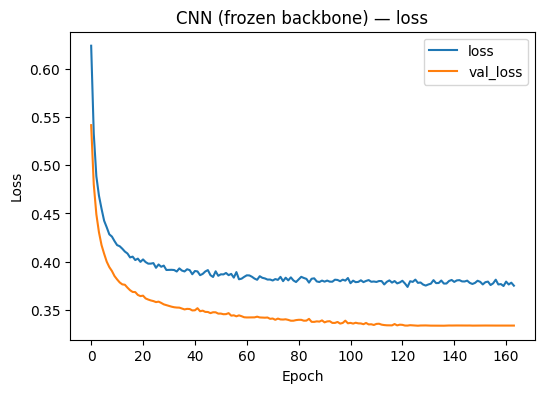

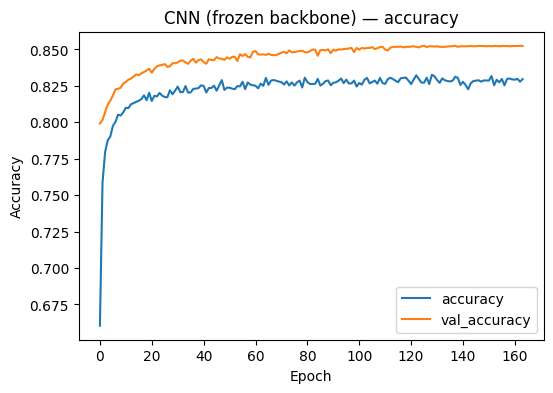

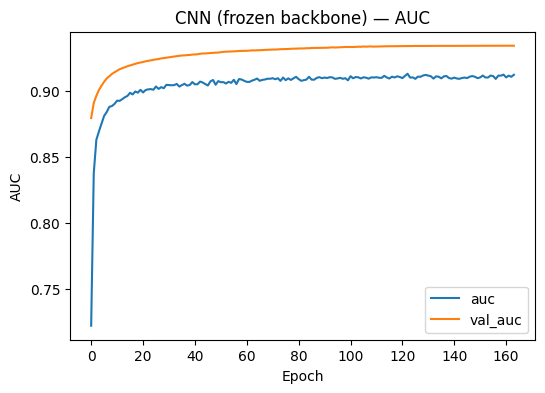

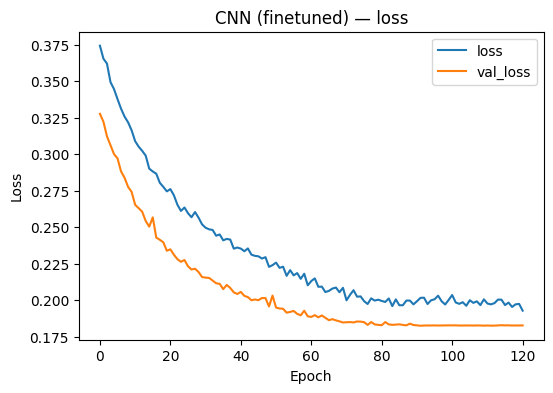

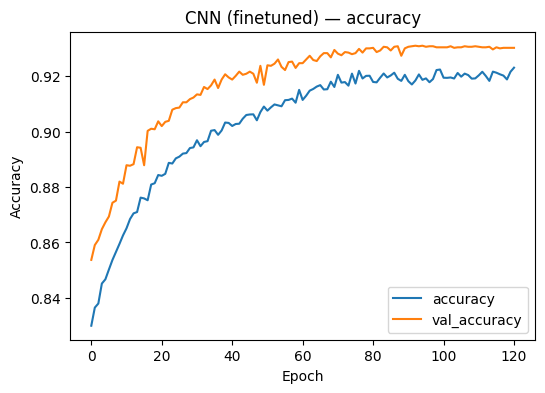

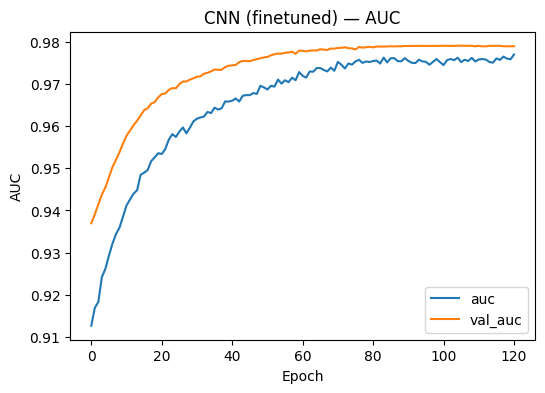

In [ ]:
def plot_history(hist, title="Training curves"):
    hist = hist.history
    plt.figure(figsize=(6,4))
    plt.plot(hist.get("loss",[]), label="loss")
    plt.plot(hist.get("val_loss",[]), label="val_loss")
    plt.title(title + " — loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

    if "accuracy" in hist or "acc" in hist:
        acc_key = "accuracy" if "accuracy" in hist else "acc"
        val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_acc"
        plt.figure(figsize=(6,4))
        plt.plot(hist.get(acc_key,[]), label=acc_key)
        plt.plot(hist.get(val_acc_key,[]), label=val_acc_key)
        plt.title(title + " — accuracy")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

    if "auc" in hist:
        plt.figure(figsize=(6,4))
        plt.plot(hist.get("auc",[]), label="auc")
        plt.plot(hist.get("val_auc",[]), label="val_auc")
        plt.title(title + " — AUC")
        plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.legend(); plt.show()

# Plot for CNN (head + finetune)
plot_history(history_cnn, "CNN (frozen backbone)")
plot_history(history_cnn_ft, "CNN (finetuned)")


# create directory for plots in save_dir
os.makedirs(os.path.join(save_dir, "plots"), exist_ok=True)

# after creating all plots, save them to save_dir
for i in plt.get_fignums():
    fig = plt.figure(i)
    fig.savefig(os.path.join(save_dir, f"plots/training_curve_{i}_{WANDB_ID}.png"))


In [ ]:
DROPOUT = '0_3333'

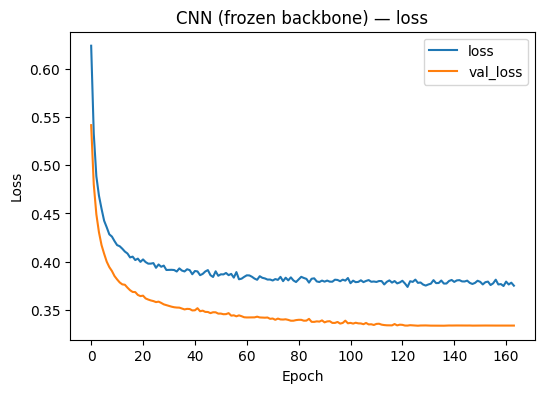

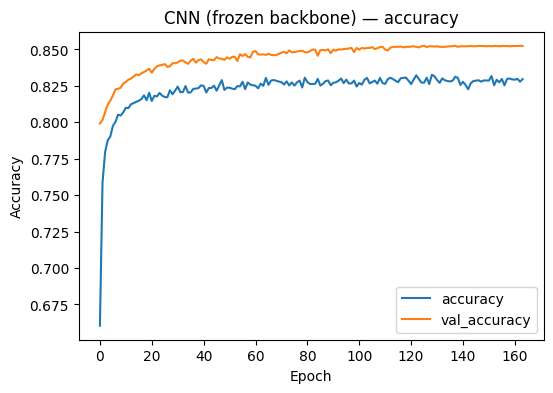

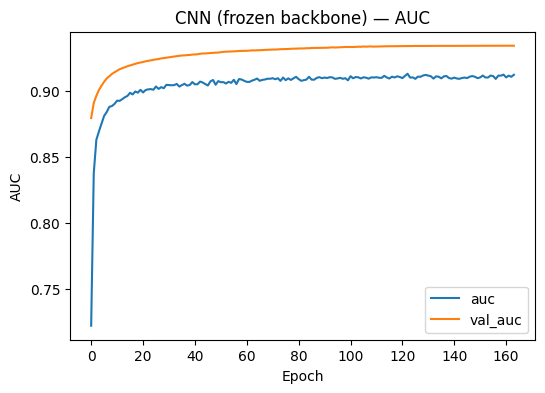

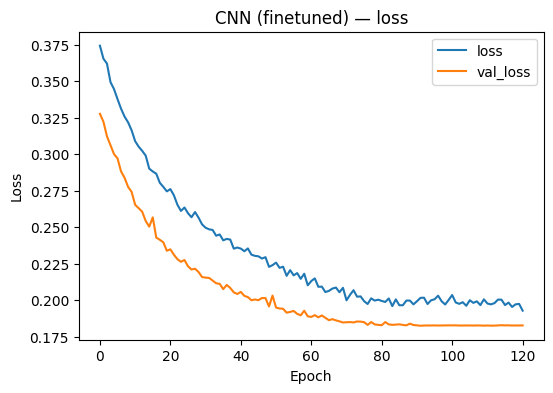

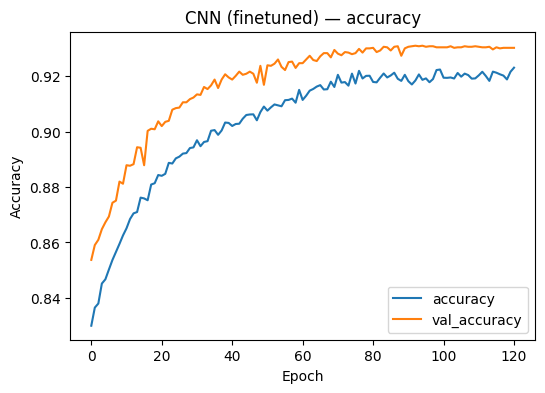

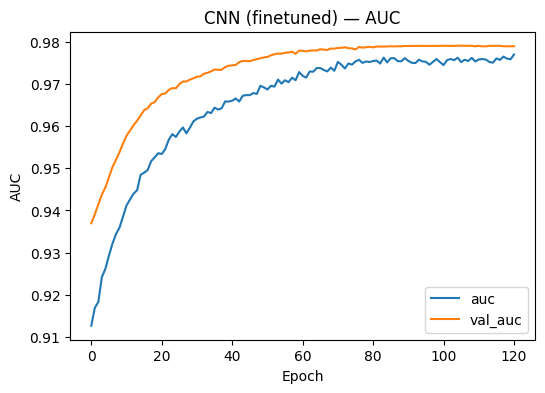

In [ ]:
"""
def plot_history(hist, title="Training curves", save_dir=None, run_id="run"):
    hist = hist.history

    # --- Loss ---
    fig = plt.figure(figsize=(6,4))
    plt.plot(hist.get("loss",[]), label="loss")
    plt.plot(hist.get("val_loss",[]), label="val_loss")
    plt.title(title + " — loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    if save_dir:
        os.makedirs(os.path.join(save_dir, "plots"), exist_ok=True)
        fig.savefig(os.path.join(save_dir, f"plots/{title}_loss_{run_id}.png"), dpi=150, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    # --- Accuracy (if present) ---
    if "accuracy" in hist or "acc" in hist:
        acc_key = "accuracy" if "accuracy" in hist else "acc"
        val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_acc"
        fig = plt.figure(figsize=(6,4))
        plt.plot(hist.get(acc_key,[]), label=acc_key)
        plt.plot(hist.get(val_acc_key,[]), label=val_acc_key)
        plt.title(title + " — accuracy")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
        if save_dir:
            fig.savefig(os.path.join(save_dir, f"plots/{title}_{MODEL_NAME}_{DROPOUT}_accuracy_{run_id}.png"), dpi=150, bbox_inches="tight")
        plt.show()
        plt.close(fig)

    # --- AUC (if present) ---
    if "auc" in hist:
        fig = plt.figure(figsize=(6,4))
        plt.plot(hist.get("auc",[]), label="auc")
        plt.plot(hist.get("val_auc",[]), label="val_auc")
        plt.title(title + " — AUC")
        plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.legend()
        if save_dir:
            fig.savefig(os.path.join(save_dir, f"plots/{title}_{MODEL_NAME}_{DROPOUT}_auc_{run_id}.png"), dpi=150, bbox_inches="tight")
        plt.show()
        plt.close(fig)

# Usage
plot_history(history_cnn,   "CNN (frozen backbone)", save_dir=save_dir, run_id=WANDB_ID)
plot_history(history_cnn_ft,"CNN (finetuned)",       save_dir=save_dir, run_id=WANDB_ID)
"""

## 3.4 Prepare final re-fit

In [ ]:
print('preparing final refit')

# Train* DataSet (val + train)
#train_star = train_ds.concatenate(val_ds).shuffle(
#    buffer_size=2048, seed=SEED, reshuffle_each_iteration=True
#)

train_star = train_ds.concatenate(val_ds)

# update W&B for refit
final_callbacks = [
    WandbMetricsLogger(log_freq="epoch"),
    WandbModelCheckpoint(
        filepath=os.path.join(save_dir, "final_refit.weights.h5"),
        monitor="auc",    # ingen val-data, så brug trænings-AUC
        mode="max",
        save_weights_only=True,
        save_best_only=True,
        save_freq="epoch",
    ),
]

wandb.log({"phase": "final_refit"})

final_model = finetune_model

preparing final refit


## 3.5 Final re-fit on train* (train+val)

In [ ]:
print('[FINAL REFIT]')

# Reuse best model weights and ReFit on train*
history_final = final_model.fit(
	train_star,
	epochs=best_ft_epoch,
	verbose=1,
	callbacks=final_callbacks
)

[FINAL REFIT]
Epoch 1/106
410/410 ━━━━━━━━━━━━━━━━━━━━ 88s 212ms/step - accuracy: 0.9199 - auc: 0.9764 - loss: 0.1961
Epoch 2/106
410/410 ━━━━━━━━━━━━━━━━━━━━ 62s 152ms/step - accuracy: 0.9171 - auc: 0.9749 - loss: 0.2011
Epoch 3/106
410/410 ━━━━━━━━━━━━━━━━━━━━ 63s 153ms/step - accuracy: 0.9215 - auc: 0.9766 - loss: 0.1946
Epoch 4/106
410/410 ━━━━━━━━━━━━━━━━━━━━ 63s 153ms/step - accuracy: 0.9187 - auc: 0.9759 - loss: 0.1978
Epoch 5/106
410/410 ━━━━━━━━━━━━━━━━━━━━ 82s 152ms/step - accuracy: 0.9180 - auc: 0.9750 - loss: 0.2001
Epoch 6/106
410/410 ━━━━━━━━━━━━━━━━━━━━ 62s 151ms/step - accuracy: 0.9221 - auc: 0.9771 - loss: 0.1924
Epoch 7/106
410/410 ━━━━━━━━━━━━━━━━━━━━ 62s 151ms/step - accuracy: 0.9215 - auc: 0.9765 - loss: 0.1947
Epoch 8/106
410/410 ━━━━━━━━━━━━━━━━━━━━ 62s 152ms/step - accuracy: 0.9168 - auc: 0.9752 - loss: 0.2004
Epoch 9/106
410/410 ━━━━━━━━━━━━━━━━━━━━ 62s 151ms/step - accuracy: 0.9215 - auc: 0.9757 - loss: 0.1981
Epoch 10/106
410/410 ━━━━━━━━━━━━━━━━━━━━ 63s 152m

In [ ]:
final_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocess (Lambda)             │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ backbone (Functional)           │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,328,283 (50.84 MB)

 Trainable params: 2,278,749 (8.69 MB)

 Non-trainable params: 6,492,034 (24.77 MB)

 Optimizer params: 4,557,500 (17.39 MB)

In [ ]:
# Save final refitted model
final_model.save(os.path.join(save_dir, f"model_final_refit_{WANDB_ID}.keras"))

## Log to W&B

In [ ]:
# W&B Artifact
artifact = wandb.Artifact(
    name=f"{MODEL_NAME}_seed{SEED}_{WANDB_ID}_final_refit",
    type="model",
    metadata={
        "model_name": MODEL_NAME,
        "img_size": IMG_SIZE,
        "seed": SEED,
        "finetune_lr": LR * 0.1,
        "refit_epochs_total": int(best_ft_epoch),
        "phase": "final_refit",
        "source_run_id": WANDB_ID,
    },
)

artifact.add_file(os.path.join(save_dir, f"model_final_refit_{WANDB_ID}.keras"))

artifact.add_file(save_dir + "/final_refit.weights.h5")
wandb.log_artifact(artifact)

# W&B Metrics 📊 for final refit
final_metrics = {
    "final_refit_best_epoch": np.argmax(history_final.history["auc"]) + 1,
    "final_refit_last_epoch": len(history_final.history["loss"]),
    "final_refit_best_auc": float(np.max(history_final.history["auc"])),
    "final_refit_last_auc": float(history_final.history["auc"][-1]),
    "final_refit_best_loss": float(np.min(history_final.history["loss"])),
    "final_refit_last_loss": float(history_final.history["loss"][-1]),
}

wandb.log(final_metrics)

print(f"[FINAL REFIT] Done ✅")
print(f"[FINAL REFIT] ✅ Model saved: {save_dir}")
print(f"[FINAL REFIT] 🪄 W&B artifact: {artifact.name}")

#finish wandb
wandb.finish()

[FINAL REFIT] Done ✅
[FINAL REFIT] ✅ Model saved: ModelWeights/efficientnetv2_b2_seed42_w58260bv
[FINAL REFIT] 🪄 W&B artifact: efficientnetv2_b2_seed42_w58260bv_final_refit


cnn_val_acc_ft,▁█
cnn_val_acc_tl,▁
cnn_val_auc_ft,▁█
cnn_val_auc_tl,▁
cnn_val_loss_ft,█▁
cnn_val_loss_tl,▁
epoch/accuracy,▁▁▁▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▆▇█▇██████▇█████████
epoch/auc,▁▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▇▇▇██████████████████
epoch/epoch,▁▂▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇██▂▂▃▃▄▄▅▅▆▆▁▂▂▂▂▂▃▃▄▄▅
epoch/learning_rate,█████████████▃▁▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+10,...


## 4 CSV Export

### 4.1 CSV with probabilities (on test)

In [ ]:
# Generate submission csv using test_ds
y_test_hat = final_model.predict(test_ds, verbose=1)
ytest_hat = pd.DataFrame({
    'Id': list(range(len(y_test_hat))),
    'Predicted': y_test_hat.reshape(-1,),
})

# create directory for csv export inside save_dir
os.makedirs(os.path.join(save_dir, "csv"), exist_ok=True)
ytest_hat.to_csv(f'{save_dir}/csv/ytest_hat_{WANDB_ID}.csv', index=False)

26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 753ms/step


### 4.2 Calculate best threshold value

In [ ]:
# === A) Find optimal threshold på val_ds (max accuracy) ===
import numpy as np
from sklearn.metrics import accuracy_score

print("[THR] Finder optimal threshold på val_ds (baseret på accuracy)")

# 1) Hent y_true og p_hat fra val_ds
y_val_true = []
for _, y in val_ds:
    y_val_true.append(y.numpy())
y_val_true = np.concatenate(y_val_true).astype(int)

# Keras .predict giver sandsynligheder (sigmoid i sidste lag)
y_val_prob = final_model.predict(val_ds, verbose=0).reshape(-1)

# 2) Grid-scan thresholds i [0.0, 1.0]
thr_grid = np.linspace(0.0, 1.0, 1001)  # opløsning 0.001
accs = []

for thr in thr_grid:
    y_val_pred = (y_val_prob >= thr).astype(int)
    accs.append(accuracy_score(y_val_true, y_val_pred))

accs = np.array(accs)
best_idx = int(np.argmax(accs))
best_thr = float(thr_grid[best_idx])
best_acc = float(accs[best_idx])

print(f"[THR] Bedste threshold = {best_thr:.3f} med val-accuracy = {best_acc:.4f}")

# (valgfrit) log til W&B
try:
    wandb.log({"threshold/best": best_thr, "threshold/val_accuracy": best_acc})
except Exception as e:
    print("[THR] W&B log skipped:", e)


[THR] Finder optimal threshold på val_ds (baseret på accuracy)
[THR] Bedste threshold = 0.479 med val-accuracy = 0.9334
[THR] W&B log skipped: You must call wandb.init() before wandb.log()


In [ ]:
"""
# calculate best threshold plot based on Cross validation k-fold 10, with 0.8 train and 0.2 val splits

# setup new datasplit from original train data
X_tr_final, X_val_final, y_tr_final, y_val_final = train_test_split(
	Xtrain, ytrain, test_size=0.2, random_state=42, stratify=ytrain
)

# use cross validation to find best threshold with 10 folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# for each fold find best threshold
best_thresholds = []
for train_index, val_index in kf.split(X_tr_final):
	X_tr_fold, X_val_fold = X_tr_final[train_index], X_tr_final[val_index]
	y_tr_fold, y_val_fold = y_tr_final[train_index], y_tr_final[val_index]

	# create datasets
	train_ds_fold = make_train_ds(X_tr_fold, y_tr_fold)
	val_ds_fold = make_eval_ds(X_val_fold, y_val_fold)

	# predict on val_ds_fold
	y_val_prob_fold = final_model.predict(val_ds_fold, verbose=0).reshape(-1)

	# get true labels
	y_val_true_fold = []
	for _, y in val_ds_fold:
		y_val_true_fold.append(y.numpy())
	y_val_true_fold = np.concatenate(y_val_true_fold).astype(int)

	# grid scan thresholds
	thr_grid = np.linspace(0.0, 1.0, 1001)
	accs = []

	for thr in thr_grid:
		y_val_pred_fold = (y_val_prob_fold >= thr).astype(int)
		accs.append(accuracy_score(y_val_true_fold, y_val_pred_fold))

	accs = np.array(accs)
	best_idx = int(np.argmax(accs))
	best_thr = float(thr_grid[best_idx])
	best_thresholds.append(best_thr)

mean_best_thr = np.mean(best_thresholds)
std_best_thr = np.std(best_thresholds)

print(f"[THR CV] Mean best threshold from CV = {mean_best_thr:.3f} ± {std_best_thr:.3f}")
"""

[THR CV] Mean best threshold from CV = 0.449 ± 0.042


### Export CSV using calculated best threshold value

In [ ]:
# === B) Generér 0/1 Kaggle-CSV fra test_ds ved brug af best_thr ===
import os
import pandas as pd

assert "best_thr" in globals(), "Kør først threshold-cellen (A), så 'best_thr' findes."

# 1) Hent P(y=1) på test
y_test_prob = final_model.predict(test_ds, verbose=1).reshape(-1)

# 2) Threshold til 0/1
y_test_label = (y_test_prob >= best_thr).astype(int)

# 3) Gem CSV
os.makedirs(os.path.join(save_dir, "csv"), exist_ok=True)
csv_path = os.path.join(save_dir, "csv", f"submission_threshold_{best_thr:.3f}_{WANDB_ID}.csv")
pd.DataFrame({"Id": np.arange(len(y_test_label)), "Predicted": y_test_label}).to_csv(csv_path, index=False)

print(f"[SUBMIT] Skrev 0/1-label CSV til:\n{csv_path}")

# (valgfrit) log filen som W&B-artifact
try:
    art = wandb.Artifact(
        name=f"{MODEL_NAME}_seed{SEED}_{WANDB_ID}_submission_thr",
        type="submission",
        metadata={"threshold": best_thr, "source_run_id": WANDB_ID}
    )
    art.add_file(csv_path)
    wandb.log_artifact(art)
except Exception as e:
    print("[SUBMIT] W&B artifact skip:", e)


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step
[SUBMIT] Skrev 0/1-label CSV til:
ModelWeights/efficientnetv2_b2_seed42_w58260bv/csv/submission_threshold_0.431_w58260bv.csv
[SUBMIT] W&B artifact skip: You must call wandb.init() before wandb.log_artifact()


### 4.2 New Alternative Threshold

### Find stabile probability threshold based on stratified bootstrap aggregation (no retraining)

Note:
Vi vælger stratificeret bootstrap-aggregation, fordi vi allerede har én færdig model, og vi kun vil finde en robust, praktisk best threshold — uden at spilde compute på at gen-træne 10 modeller (CV + K-Fold 10).

In [ ]:
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

print("[THR BOOT] Finder stabil threshold med stratificeret bootstrap på hele train")

#valida on Xtrain, ytrain to avoid leakage
y_train_prob = final_model.predict(make_eval_ds(Xtrain, ytrain), verbose=0).reshape(-1)
y_train_true = ytrain.astype(int)

# generate a evenly spaced grid of 10001 possible thresholds between 0.0 and 1.0.
thr_grid = np.linspace(0.0, 1.0, 10001)

def best_thr_on(y_true, y_prob):
    accs = [accuracy_score(y_true, (y_prob >= t).astype(int)) for t in thr_grid]
    return float(thr_grid[int(np.argmax(accs))])

# 3) Repeated stratified holdout (hurtig) + bootstrap aggregating
B = 50  # number of repetitions; set e.g. 50 for more stability
sss = StratifiedShuffleSplit(n_splits=B, test_size=0.2, random_state=42)

ths = []
for b, (_, val_idx) in enumerate(sss.split(y_train_prob, y_train_true), start=1):
    y_true_b = y_train_true[val_idx]
    y_prob_b = y_train_prob[val_idx]
    thr_b = best_thr_on(y_true_b, y_prob_b)
    ths.append(thr_b)
    # print(f"  [BOOT {b:02d}] thr={thr_b:.3f}")  # valgfri debug

# 4) Robust sammendrag
mean_best_thr = float(np.mean(ths))
median_best_thr = float(np.median(ths))
std_best_thr = float(np.std(ths))

# 5) Alternativ: "global" optimal på hele train (samme scores)
global_accs = [accuracy_score(y_train_true, (y_train_prob >= t).astype(int)) for t in thr_grid]
global_best_thr = float(thr_grid[int(np.argmax(global_accs))])

print(f"[THR BOOT] mean={mean_best_thr:.3f} ± {std_best_thr:.3f} | median={median_best_thr:.3f} | global={global_best_thr:.3f}")

# 6) Vælg hvilken du vil bruge til submission (jeg anbefaler median for robusthed)
best_thr = median_best_thr

[THR BOOT] Finder stabil threshold med stratificeret bootstrap på hele train
[THR BOOT] mean=0.460 ± 0.035 | median=0.455 | global=0.426


## Output CSV using calculated alternative threshold (median)

In [ ]:
# === B) Generér 0/1 Kaggle-CSV fra test_ds ved brug af best_thr ===
import os
import pandas as pd

assert "best_thr" in globals(), "Kør først threshold-cellen (A), så 'best_thr' findes."

# 1) Hent P(y=1) på test
y_test_prob = final_model.predict(test_ds, verbose=1).reshape(-1)

# 2) Threshold til 0/1
y_test_label = (y_test_prob >= best_thr).astype(int)

# 3) Gem CSV
os.makedirs(os.path.join(save_dir, "csv"), exist_ok=True)
csv_path = os.path.join(save_dir, "csv", f"submission_threshold_{MODEL_NAME}_{DROPOUT}_{best_thr:.3f}_{WANDB_ID}_submission_new_thr.csv")
pd.DataFrame({"Id": np.arange(len(y_test_label)), "Predicted": y_test_label}).to_csv(csv_path, index=False)

print(f"[SUBMIT] Skrev 0/1-label CSV til:\n{csv_path}")

# (valgfrit) log filen som W&B-artifact
try:
    art = wandb.Artifact(
        name=f"{MODEL_NAME}_{DROPOUT}_seed{SEED}_{WANDB_ID}_submission_new_thr",
        type="submission",
        metadata={"threshold": best_thr, "source_run_id": WANDB_ID}
    )
    art.add_file(csv_path)
    wandb.log_artifact(art)
except Exception as e:
    print("[SUBMIT] W&B artifact skip:", e)


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step
[SUBMIT] Skrev 0/1-label CSV til:
ModelWeights/efficientnetv2_b2_seed42_w58260bv/csv/submission_threshold_efficientnetv2_b2_0_3333_0.455_w58260bv_submission_new_thr.csv
[SUBMIT] W&B artifact skip: You must call wandb.init() before wandb.log_artifact()
